# Exploring the effect of class imbalance on model performance

Starting with the Titanic dataset as a balanced one, we will make the training data more and more imbalanced to show the effects of trying to train with fewer and fewer positive samples.

In [1]:
import numpy as np
import pandas as pd

In [26]:
from helpers import preprocessor_pipeline
from sklearn.model_selection import train_test_split

## Load data and split into train/val

In [32]:
train = pd.read_csv("data/train.csv")

train, val = train_test_split(train, test_size=0.1, random_state=1, stratify=train['Survived'])
train, val = (train.copy(), val.copy())

## Preprocessing the data

In [33]:
categorical_fts = ['Pclass', 'Embarked', "Sex"]
numerical_fts = ['Age', 'Fare']

input_features = numerical_fts + categorical_fts

In [34]:
preprocessor = preprocessor_pipeline(scaling=True)

In [35]:
train_tf = preprocessor.fit_transform(train[input_features])
train_y = train['Survived'].values

val_tf = preprocessor.transform(val[input_features])
val_y = val['Survived'].values

## Modelling

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
clf = RandomForestClassifier()

In [39]:
trained_model = clf.fit(train_tf, train_y)

## Validation

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
scores = clf.predict_proba(val_tf)[:, 1]

In [64]:
y_hat = np.where(scores, 1, 0)

In [65]:
print(classification_report(y_hat, val_y))
print(confusion_matrix(y_hat, val_y))

              precision    recall  f1-score   support

           0       0.13      0.78      0.22         9
           1       0.94      0.41      0.57        81

    accuracy                           0.44        90
   macro avg       0.54      0.59      0.39        90
weighted avg       0.86      0.44      0.53        90

[[ 7  2]
 [48 33]]


In [66]:
import matplotlib.pyplot as plt

(array([35., 12.,  9.,  1.,  3.,  5.,  3.,  3.,  4., 15.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

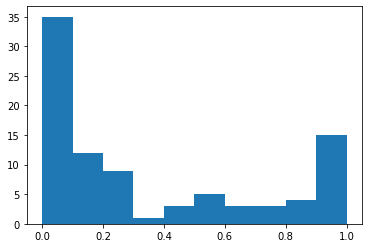

In [67]:
plt.hist(scores)